In [38]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from math import atan2, degrees

In [39]:
# Hàm tính hộp giới hạn xoay từ hộp giới hạn thẳng đứng
def get_rotated_box(image, x1, y1, x2, y2):
    # Kiểm tra tọa độ hợp lệ
    if x1 >= x2 or y1 >= y2 or x1 < 0 or y1 < 0 or x2 > image.shape[1] or y2 > image.shape[0]:
        return None, 0, None

    # Cắt vùng ảnh chứa khung ảnh
    roi = image[y1:y2, x1:x2]
    if roi.size == 0:
        return None, 0, None

    # Chuyển sang ảnh xám và làm mờ để giảm nhiễu
    try:
        gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    except cv2.error:
        return None, 0, None

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Phát hiện cạnh bằng Canny
    edges = cv2.Canny(blurred, 50, 150)

    # Tìm các đường viền (contours)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, 0, None

    # Lấy đường viền lớn nhất (dựa trên diện tích)
    largest_contour = max(contours, key=cv2.contourArea)

    # Tính hộp giới hạn xoay nhỏ nhất bao quanh đường viền
    rect = cv2.minAreaRect(largest_contour)
    angle = rect[2]  # Góc nghiêng (độ)
    box = cv2.boxPoints(rect)  # Tọa độ 4 góc của hộp giới hạn xoay
    box = box.astype(int)  # Chuyển về tọa độ nguyên

    # Điều chỉnh tọa độ về vị trí gốc của ảnh
    box[:, 0] += x1
    box[:, 1] += y1

    # Điều chỉnh tọa độ của đường viền về vị trí gốc của ảnh
    adjusted_contour = largest_contour.copy()
    adjusted_contour[:, :, 0] += x1  # Điều chỉnh tọa độ x
    adjusted_contour[:, :, 1] += y1  # Điều chỉnh tọa độ y

    return box, angle, adjusted_contour

# Hàm kiểm tra xem điểm có nằm trong hộp giới hạn xoay không
def point_in_rotated_box(point, box):
    if box is None:
        return False
    return cv2.pointPolygonTest(box, point, False) >= 0

## Model Loading

In [40]:
def load_model(model_path):
    """Load YOLO model and display basic info"""
    model = YOLO(model_path)
    print(f"Model type: {type(model.model)}")
    print(f"Model device: {model.device}")
    print(f"Model classes: {model.names}")
    
    print("\nModel architecture:")
    print(model.model)
    
    if hasattr(model.model, 'hyp'):
        print("\nTraining hyperparameters:")
        print(model.model.hyp)
    
    return model

## Image Processing

In [41]:
def load_and_preprocess_image(image_path):
    """Load image and convert to RGB format"""
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

## Rotated Box Analysis and Visualization

In [42]:
def analyze_detection(model, image_rgb):
    """Analyze rotated detection results and check if center is in detected object"""
    # 3.2. Tính toán tâm của bức ảnh
    height, width, _ = image_rgb.shape
    center_x = width // 2
    center_y = height // 2
    center_point = (center_x, center_y)

    # 3.3. Thực hiện nhận diện với YOLOv8
    results = model(image_rgb)  # Ngưỡng độ tin cậy thấp để tăng khả năng phát hiện

    # 3.4. Biến kiểm tra
    center_in_photo_frame = False
    photo_frame_found = False

    # 3.5. Xử lý kết quả nhận diện
    for result in results[0].boxes:
        x1, y1, x2, y2 = map(int, result.xyxy[0])  # Tọa độ hộp giới hạn thẳng đứng
        label = model.names[int(result.cls)]  # Tên nhãn
        confidence = float(result.conf)  # Chuyển Tensor sang float

        # Chỉ xử lý nếu nhãn là target_label
        if label == 'bia':
            photo_frame_found = True

            # Vẽ hộp giới hạn thẳng đứng (màu đỏ)
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # Tính hộp giới hạn xoay và lấy đường viền
            rotated_box, angle, contour = get_rotated_box(image_rgb, x1, y1, x2, y2)

            # Kiểm tra xem tâm có nằm trong hộp giới hạn xoay không
            if rotated_box is not None:
                center_in_photo_frame = point_in_rotated_box(center_point, rotated_box)

                # Vẽ đường viền (màu vàng)
                if contour is not None:
                    cv2.drawContours(image_rgb, [contour], -1, (255, 255, 0), 2)

                # Vẽ hộp giới hạn xoay (màu xanh lá cây)
                cv2.polylines(image_rgb, [rotated_box], True, (0, 255, 0), 2)

                # Vẽ nhãn với thông tin góc nghiêng
                label_text = f"{label}: {confidence:.2f}, Angle: {angle:.1f}°"
                (text_width, text_height), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                cv2.rectangle(image_rgb, (x1, y1 - 20), (x1 + text_width, y1), (0, 255, 0), -1)
                cv2.putText(image_rgb, label_text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

                print(f"Vật thể: {label}, Độ tin cậy: {confidence:.2f}, Góc nghiêng: {angle:.1f}°, Tọa độ 4 góc (xoay): {rotated_box.flatten()}")
                break

    # 3.6. Vẽ tâm của bức ảnh (chấm đỏ)
    cv2.circle(image_rgb, (center_x, center_y), 5, (255, 0, 0), -1)

    # 3.7. Hiển thị kết quả kiểm tra
    if not photo_frame_found:
        print(f"Không tìm thấy bia trong ảnh.")
    else:
        if center_in_photo_frame:
            print(f"Tâm của bức ảnh NẰM trong bia.")
        else:
            print(f"Tâm của bức ảnh KHÔNG nằm trong bia.")

    return image_rgb

def display_results(image):
    """Display processed image with detections"""
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

## Main Execution

Model type: <class 'ultralytics.nn.tasks.DetectionModel'>
Model device: cpu
Model classes: {0: 'bia'}

Model architecture:
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b

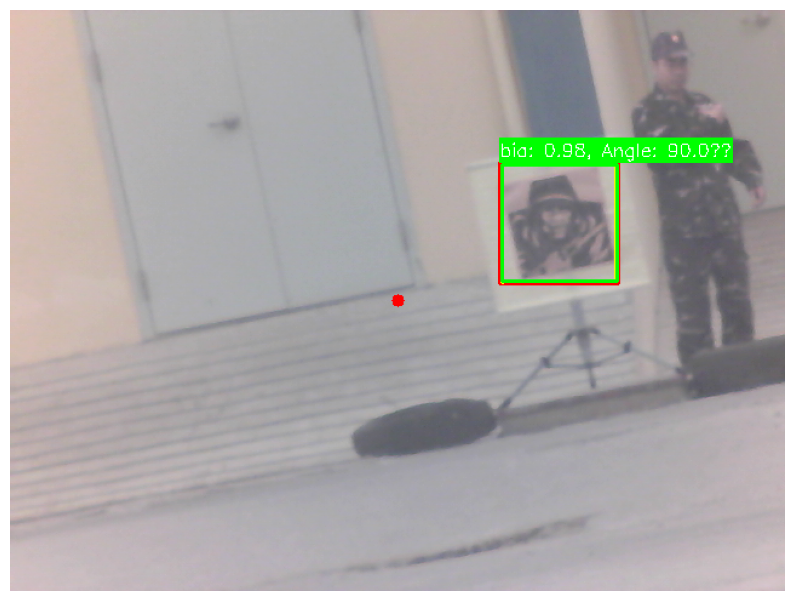

In [43]:
def main():
    """Main function to run the rotated object detection pipeline"""
    model_path = "yolo-models\\yolo11x_bia-4.pt"
    image_path = "images\\bo du lieu bia so 4\\bia4 (1).bmp"
    
    try:
        # Load model
        model = load_model(model_path)
        
        # Load and preprocess image
        image = load_and_preprocess_image(image_path)
                
        # Analyze detections and visualize
        processed_image = analyze_detection(model, image)
        
        # Display final results
        display_results(processed_image)
        
    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()